In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
PATH = 'chest_xray/train'
im_path = {'n':[],
           'p':[]}
for i in os.listdir(PATH):
    for j in os.listdir(os.path.join(PATH, i)):
        if i == 'PNEUMONIA':
            im_path['p'].append(os.path.join(PATH,i,j))
        elif i == 'NORMAL':
            im_path['n'].append(os.path.join(PATH,i,j))

In [2]:
PATH = './chest_xray'
data_transforms = {
    'train':transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
    'val':transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), data_transforms[x])
                  for x in ['train', 'val']}

100%|██████████| 2/2 [00:00<00:00, 93.44it/s]


In [3]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True)
              for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [5]:
dataset_sizes

{'train': 5216, 'val': 16}

In [6]:
class_names = image_datasets['train'].classes

In [7]:
class_names

['NORMAL', 'PNEUMONIA']

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

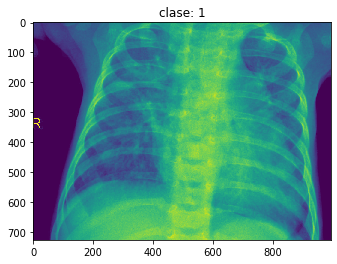

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
plt.imshow(inputs.numpy()[0,0])
plt.title(f'clase: {classes.numpy()[0]}');

In [10]:
vgg16 = torchvision.models.vgg16(pretrained=True)

In [11]:
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)

In [12]:
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [13]:
vgg16 = vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [15]:
n_epochs = 5

train_loss, eval_loss = [],[]
for epoch in range(n_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()
        else:
            vgg16.eval()
            
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    train_loss.append(loss.detach().to('cpu').numpy())
                else:
                    eval_loss.append(loss.to('cpu').numpy())

  0%|          | 14/5216 [00:20<2:06:48,  1.46s/it]


KeyboardInterrupt: 

In [17]:
train_loss = np.array(train_loss)
eval_loss = np.array(eval_loss)

In [66]:
vgg16.eval()
aciertos = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    outputs = vgg16(inputs)
    _, preds = torch.max(outputs, 1)
    aciertos.append(preds.to('cpu').numpy()[0]==labels.numpy()[0])

In [67]:
np.sum(aciertos)/len(aciertos)

0.5